___
# Report classification using manually extracted (gold standard) annotations
___

In [1]:
import numpy as np
import pandas as pd
import utils
from time import time

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import *

# Display wide columns
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

___
# Data preparation

In [2]:
# Load the development set
df = pd.read_csv("../datasets/reports_dev.csv")

# Add counts of gold standard annotations
df = utils.ann2counts(df)

# Define features and labels
feature_names = utils.get_feature_names("concepts") + utils.get_feature_names("composite")
X = df[feature_names] 
y = df.y
groups = df.patient_id

print("Using %d features." % X.shape[1])

Using 17 features.


___
# Model selection
### Quick&dirty trying a few algorithms

In [3]:
clfs = (
    LogisticRegression(solver='saga', penalty='none', 
                       max_iter=5000, class_weight='balanced', random_state=42),
    LogisticRegression(solver='saga', penalty='l1', 
                       max_iter=5000, class_weight='balanced', random_state=42),
    LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, 
                       max_iter=5000, class_weight='balanced', random_state=42),
    LogisticRegression(solver='saga', 
                       max_iter=5000, class_weight='balanced', random_state=42),
)

for clf in clfs:
    utils.score_cv(clf, X, y, groups)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', max_iter=5000, penalty='none',
                   random_state=42, solver='saga')
train time: 1.247s
ROC AUC score: 1.000 (+/- 0.00)
AP score: 1.000 (+/- 0.00)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', max_iter=5000, penalty='l1',
                   random_state=42, solver='saga')
train time: 0.161s
ROC AUC score: 1.000 (+/- 0.00)
AP score: 1.000 (+/- 0.00)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', l1_ratio=0.5, max_iter=5000,
                   penalty='elasticnet', random_state=42, solver='saga')
train time: 0.101s
ROC AUC score: 1.000 (+/- 0.00)
AP score: 1.000 (+/- 0.00)

____

### Tune the final model

In [4]:
clf = LogisticRegression(solver='saga', penalty='elasticnet', 
                         max_iter=5000, class_weight='balanced', random_state=42)

c = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
l1_ratio = [1.0, 0.75, 0.5, 0.25, 0.0]
param_grid = {
    'C': c, 
    'l1_ratio': l1_ratio,
}

best_params = utils.search_params(clf, 'grid', param_grid, X, y, groups)
best_model = clf.set_params(**best_params)

Best for current fold: 1.000 using {'C': 0.1, 'l1_ratio': 0.75}
0.133 (+/- 0.070) with: {'C': 1e-05, 'l1_ratio': 1.0}
0.133 (+/- 0.070) with: {'C': 1e-05, 'l1_ratio': 0.75}
0.133 (+/- 0.070) with: {'C': 1e-05, 'l1_ratio': 0.5}
0.133 (+/- 0.070) with: {'C': 1e-05, 'l1_ratio': 0.25}
0.979 (+/- 0.039) with: {'C': 1e-05, 'l1_ratio': 0.0}
0.133 (+/- 0.070) with: {'C': 0.0001, 'l1_ratio': 1.0}
0.133 (+/- 0.070) with: {'C': 0.0001, 'l1_ratio': 0.75}
0.133 (+/- 0.070) with: {'C': 0.0001, 'l1_ratio': 0.5}
0.133 (+/- 0.070) with: {'C': 0.0001, 'l1_ratio': 0.25}
0.979 (+/- 0.039) with: {'C': 0.0001, 'l1_ratio': 0.0}
0.133 (+/- 0.070) with: {'C': 0.001, 'l1_ratio': 1.0}
0.133 (+/- 0.070) with: {'C': 0.001, 'l1_ratio': 0.75}
0.133 (+/- 0.070) with: {'C': 0.001, 'l1_ratio': 0.5}
0.133 (+/- 0.070) with: {'C': 0.001, 'l1_ratio': 0.25}
0.984 (+/- 0.028) with: {'C': 0.001, 'l1_ratio': 0.0}
0.958 (+/- 0.110) with: {'C': 0.01, 'l1_ratio': 1.0}
0.968 (+/- 0.096) with: {'C': 0.01, 'l1_ratio': 0.75}
0.994 (+

___
# Model evaluation
### Evaluate the final model using CV

In [5]:
# Model performance in each CV fold
utils.score_cv(best_model, X, y, groups)

# Make predictions for each CV fold
y_proba = utils.predict_cv(best_model, X, y, groups, options=[])

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.75, max_iter=5000,
                   penalty='elasticnet', random_state=42, solver='saga')
train time: 0.116s
ROC AUC score: 1.000 (+/- 0.00)
AP score: 1.000 (+/- 0.00)



The threshold optimises F1-score calculated from the PR curve.
Best threshold for the model = 0.267, F1-score = 0.970

Proportion of labels predicted as positive: 14.8%
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       198
           1       0.94      1.00      0.97        32

    accuracy                           0.99       230
   macro avg       0.97      0.99      0.98       230
weighted avg       0.99      0.99      0.99       230

PPV: 0.94, Sensitivity: 1.00, Specificity: 0.99


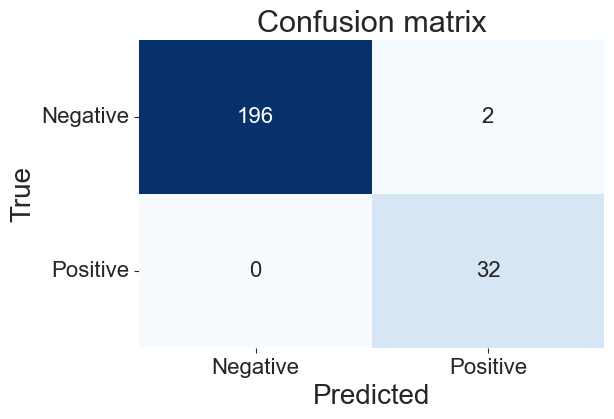

In [6]:
# Find the optimal threshold using aggregated predictions
thresh = utils.select_threshold(y, y_proba)

# Evaluate classification using aggregated predictions
utils.evaluate_classification(y, y_proba, thresh, filename="gs_cv")

### Train the final model on the full development set

In [7]:
# Re-train the final model on the full training set
best_model.fit(X, y)

LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.75, max_iter=5000,
                   penalty='elasticnet', random_state=42, solver='saga')

### Examine model coefficients

In [8]:
intercept = best_model.intercept_
coefs = best_model.coef_[0]
null_coef = (coefs == 0).sum()
print("The intercept = %.2f." % intercept)
print("%d coefficients are set to 0.0, %d features remaining:" % (null_coef, len(feature_names) - null_coef))
for ft, w in zip(feature_names, coefs):
    print('{0:30}  {1}'.format(ft, w.round(2)))

The intercept = -2.36.
14 coefficients are set to 0.0, 3 features remaining:
ClinicalQuery                   0.0
FungalDescriptor                0.0
Fungus                          0.26
Invasiveness                    0.0
Stain                           0.0
SampleType                      0.0
positive                        1.85
equivocal                       0.0
negative                        0.0
affirmedFungalDescriptor        0.42
affirmedFungus                  0.0
affirmedInvasiveness            0.0
affirmedStain                   0.0
negatedFungalDescriptor         0.0
negatedFungus                   0.0
negatedInvasiveness             0.0
negatedStain                    0.0


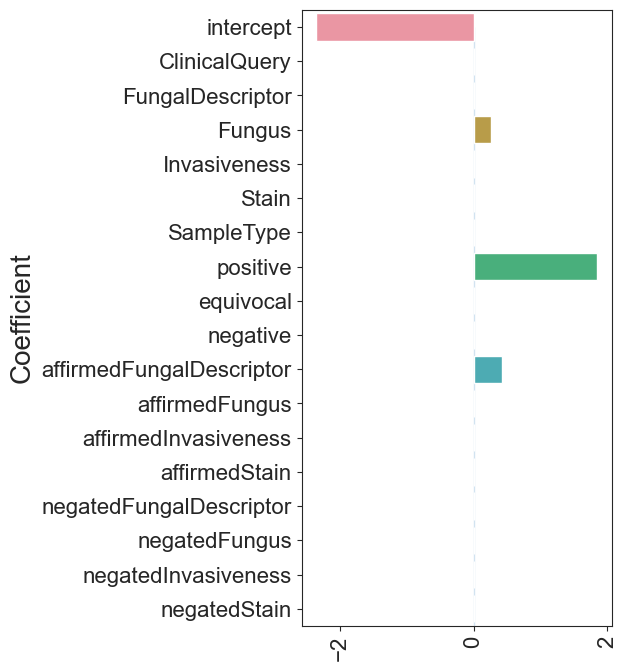

In [9]:
utils.plot_coefficients(intercept, coefs, feature_names, filename="gs")

### Test the final model on test data

In [10]:
# Load the test set
df_test = pd.read_csv("../datasets/reports_test.csv")

# Add counts of gold standard annotations
df_test = utils.ann2counts(df_test)

# Define test set features and labels
X_test = df_test[feature_names]
y_test = df_test.y

# Make predictions
y_proba = best_model.predict_proba(X_test)
y_proba = y_proba[:,1]

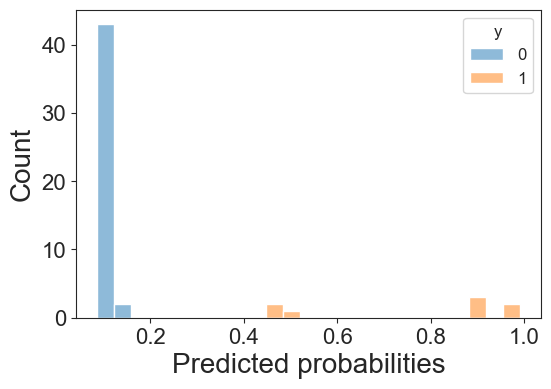

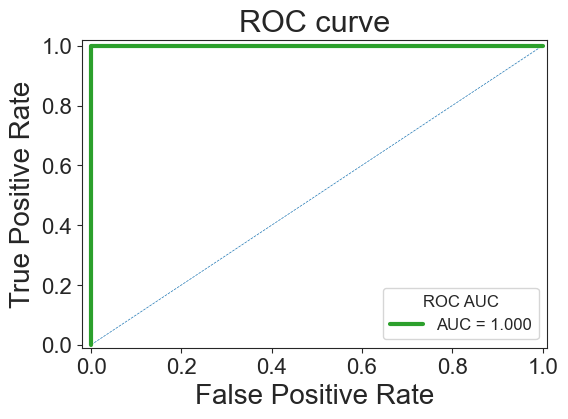

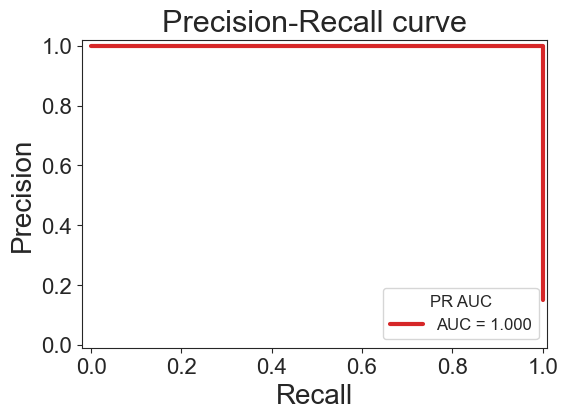

In [11]:
# Plot curves
utils.plot_curves(y_test, y_proba, filename="gs_test")

Proportion of labels predicted as positive: 15.1%
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00         8

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53

PPV: 1.00, Sensitivity: 1.00, Specificity: 1.00


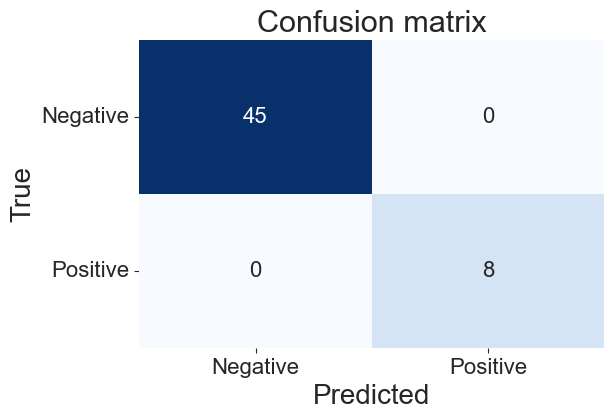

In [12]:
# Evaluate classification
_ = utils.evaluate_classification(y_test, y_proba, thresh, filename="gs_test")